In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm

%matplotlib inline

In [17]:
class ES:
    '''
    :param int mode: mode=1 for ES(µ + λ), mode=2 for ES(µ, λ)

    '''
    def __init__(self, mode, iters, mu, lambda_, chromosome_len, eval_f, domain_l=0, domain_r=1, K=0.6, tau0=None, tau1=None):
        self.mode = mode
        self.iters = iters
        self.mu = mu
        self.lambda_ = lambda_
        self.d = chromosome_len
        self.eval_f = eval_f
        self.K = K
        self.tau0 = tau0
        self.tau1 = tau1
        
        if self.tau0 is None:
            self.tau0 = K / np.sqrt(2 * np.sqrt(self.d))
            
        if self.tau1 is None:
            self.tau1 =  K / np.sqrt(2 * self.d)
        
        self.P = np.hstack((
            np.random.uniform(
                low=np.array(domain_l),
                high=np.array(domain_r),
                size=(self.mu, self.d)
            ), # chromosome
            
            np.random.uniform(
                low=np.ones(len(domain_r)) - 1, # 0
                high=np.array(domain_r) / np.array(domain_r).max(), # ?
                size=(self.mu, self.d)
            )  # sigmas 
        ))
        self.cost = eval_f(self.P[:, :self.d])
        self.cost_history = []
        self.population_history = []
        self.sigmas_history = []
        self.best_sigmas_history = []
        
    def parents_selection(self):
        # Softmax
#         fitness_values = np.exp(self.cost) / np.sum(np.exp(self.cost))
        
        # Normalize
        fitness_values = self.cost
        if abs(self.cost.max() - self.cost.min()) > 1e-3:
            fitness_values = (self.cost - self.cost.min()) / (self.cost.max() - self.cost.min())
        fitness_values /= fitness_values.sum()
            
        ids = np.random.choice(
            np.arange(self.cost.size),
            size=self.lambda_,
            replace=True,
            p=fitness_values
        )
        return self.P[ids]
    
    
    def mutation(self, parents):
        X = parents[:, :self.d]
        Sigmas = parents[:, self.d:]

        E = np.random.normal(0, self.tau1, size=Sigmas.shape)
        eps_o = np.random.normal(0, self.tau0)
        Sigmas *= np.exp(E + eps_o)
    
        return np.hstack((
            X + np.random.normal(0, 1, size=Sigmas.shape) * Sigmas,
            Sigmas
        ))
    
    
    def replacement(self, children, children_cost):
        P, costs = None, None
        if self.mode == 1: # ES(µ + λ)
            P = np.vstack((self.P, children))
            costs = np.hstack((self.cost, children_cost))
        
        elif self.mode == 2: # ES(µ, λ)
            P = children
            costs = children_cost
        
        else:
            raise ValueError(f'Wrong mode! {self.mode}')
            
        best = np.argsort(costs)[:self.mu]
        return P[best], costs[best]
            
        
        
    def run(self):
        desc = ['ES(µ + λ)', 'ES(µ, λ)'][self.mode - 1]
        for i in tqdm(range(self.iters), desc=f'{desc}', position=0):
            children = self.parents_selection()
            children = self.mutation(children)
            children_cost = self.eval_f(children[:, :self.d])
            
            self.P, self.cost = self.replacement(children, children_cost)
            self.cost_history.append((self.cost.min(), self.cost.mean(), self.cost.max()))
            self.population_history.append(self.P[:, :self.d])
            self.sigmas_history.append(self.P[:, self.d:].mean(axis=0)) # mean of sigmas in population
            
            best_indi = self.cost.argmin()
            self.best_sigmas_history.append(self.P[:, self.d:][best_indi]) # sigmas of best indi
            
    def plot_cost(self):
        self.cost_history = np.array(self.cost_history)
        plt.figure(figsize=(15, 5))
        plt.plot(self.cost_history)
        mini_id = self.cost_history[:, 0].argmin()
        mini_val = self.cost_history[:, 0][mini_id]
        population_batch = self.population_history[mini_id]
        population_mini_id = self.eval_f(population_batch[:, :self.d]).argmin()
        self.best_individual = population_batch[population_mini_id]
        desc = ['ES(µ + λ)', 'ES(µ, λ)'][self.mode - 1]
        plt.title(f'{desc} --> POPULATION SIZE: {self.mu}  |  CHROMOSOME LEN: {self.d}  |  ITERS: {self.iters}  |  BEST_ITER: {mini_id}  |  MIN: {mini_val :.3f}')
        plt.legend(['Min','Mean', 'Max'], loc='upper right')
#         print(f'Best individual: {best_individual[:self.d]}')
#         print(f'Func val: {self.eval_f(np.array(best_individual[:self.d])[np.newaxis])}')
        
    def plot_sigmas(self, sigmas):
        plt.figure(figsize=(15, 5))
        plt.title('Sigmas')
        plt.plot(sigmas)
        plt.show()

# Test Functions for Unconstrained Global Optimization.

## 1. Sphere function

In [18]:
def sphere(P):
    return np.sum(
        P**2,
        axis=1
    )

In [19]:
model = ES(mode=1, iters=1000, mu=100, lambda_=150, chromosome_len=2, eval_f=sphere, 
           domain_l=[-5.12] * 2, domain_r=[5.12] * 2) 

model.run()

ES(µ + λ): 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5664.85it/s]


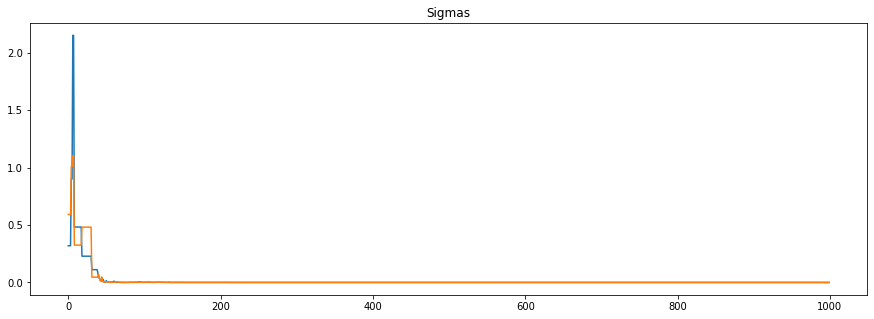

In [20]:
model.plot_sigmas(model.best_sigmas_history)

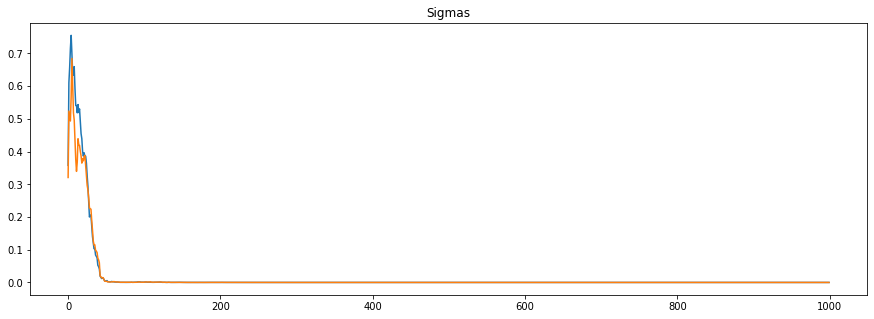

In [21]:
model.plot_sigmas(model.sigmas_history)

### 1.1 R^2

ES(µ + λ): 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6385.22it/s]


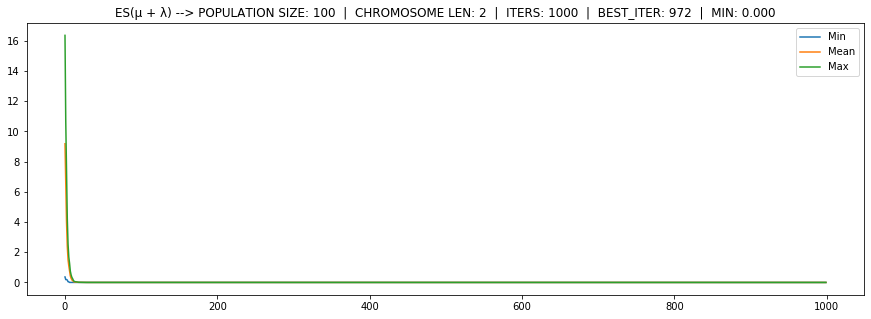

In [106]:
model = ES(mode=1, iters=1000, mu=100, lambda_=150, chromosome_len=2, eval_f=sphere, 
           domain_l=[-5.12] * 2, domain_r=[5.12] * 2) 
model.run()
model.plot_cost()

ES(µ, λ): 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6468.90it/s]


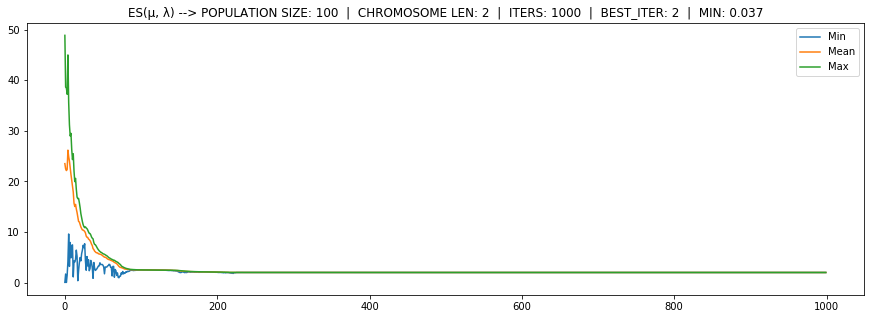

In [5]:
model = ES(mode=2, iters=1000, mu=100, lambda_=150, chromosome_len=2, eval_f=sphere, 
           domain_l=[-5.12] * 2, domain_r=[5.12] * 2) 
model.run()
model.plot_cost()

### 1.2 R^10

ES(µ + λ): 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 654.30it/s]


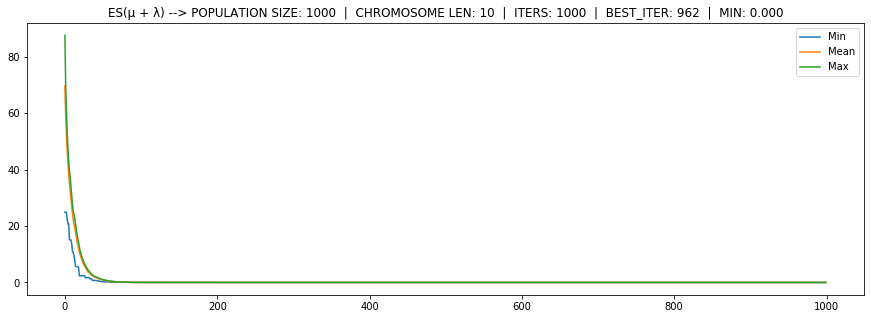

In [25]:
R = 10
model = ES(mode=1, iters=1000, mu=1000, lambda_=1500, chromosome_len=R, eval_f=sphere, 
           domain_l=[-5.12] * R, domain_r=[5.12] * R) 
model.run()
model.plot_cost()

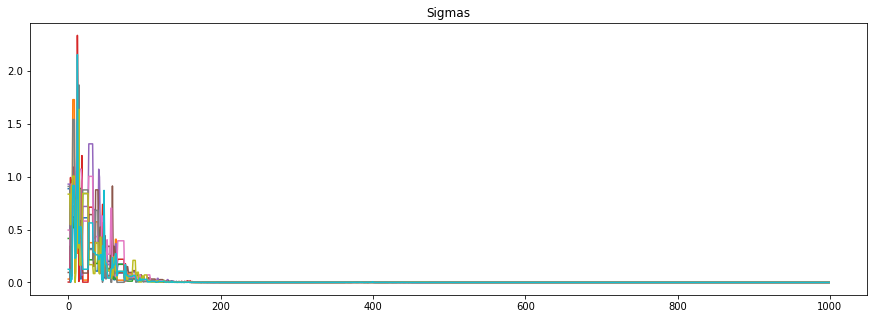

In [26]:
model.plot_sigmas(model.best_sigmas_history)

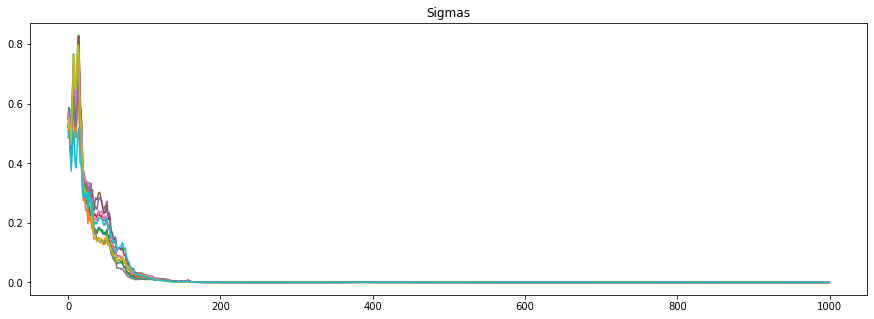

In [27]:
model.plot_sigmas(model.sigmas_history)

ES(µ, λ): 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 694.21it/s]


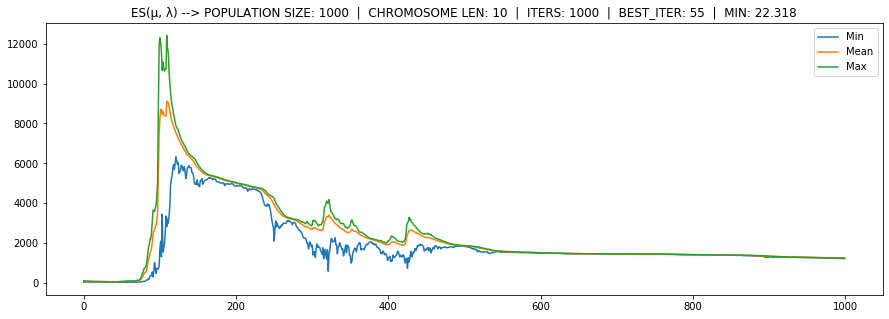

In [22]:
R = 10
model = ES(mode=2, iters=1000, mu=1000, lambda_=1500, chromosome_len=R, eval_f=sphere, 
           domain_l=[-5.12] * R, domain_r=[5.12] * R) 
model.run()
model.plot_cost()

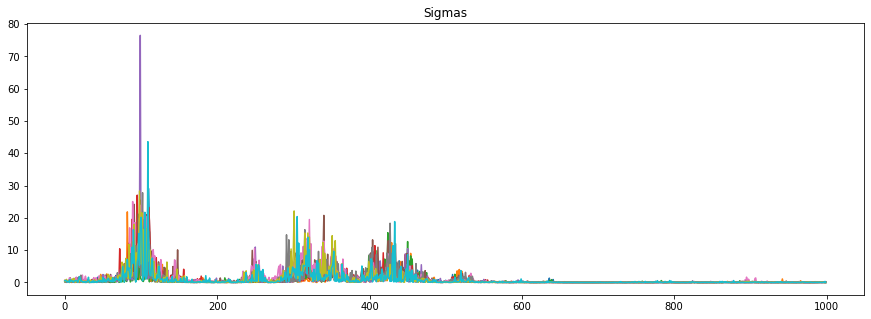

In [23]:
model.plot_sigmas(model.best_sigmas_history)

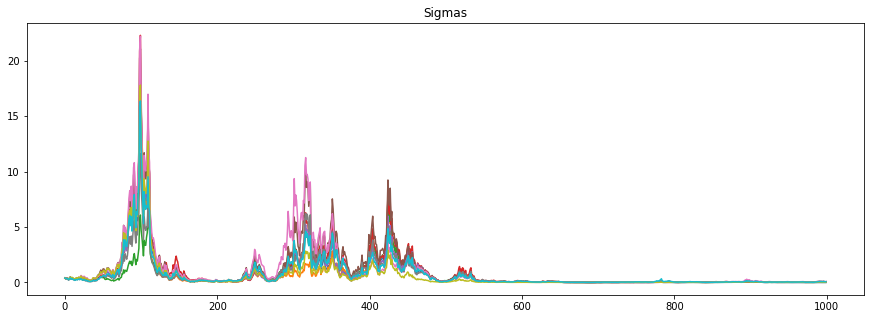

In [24]:
model.plot_sigmas(model.sigmas_history)

### 1.3 R^50

ES(µ + λ): 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.56it/s]


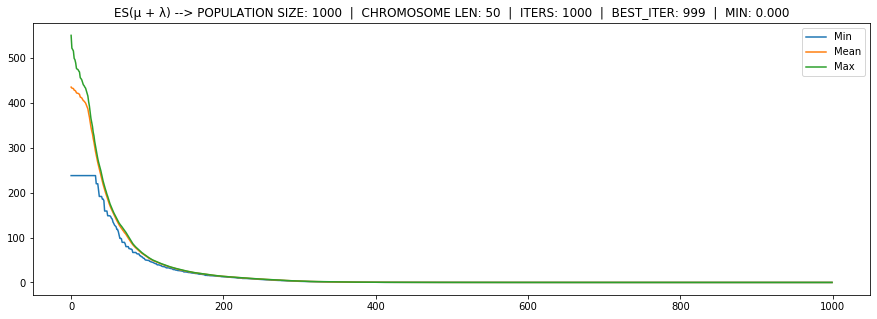

In [8]:
R = 50
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=sphere, 
           domain_l=[-5.12] * R, domain_r=[5.12] * R) 
model.run()
model.plot_cost()

ES(µ, λ): 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.67it/s]


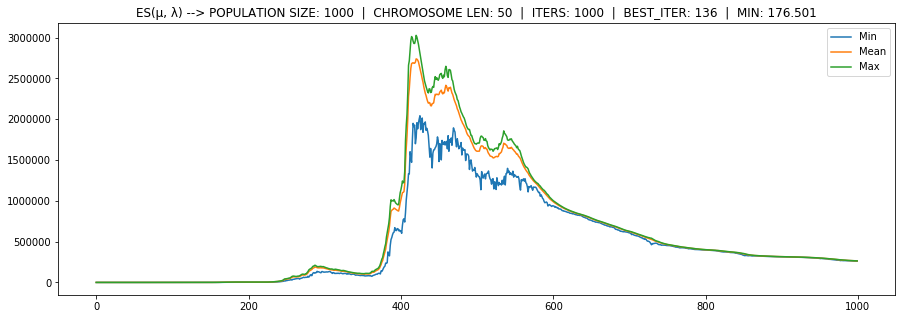

In [28]:
R = 50
model = ES(mode=2, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=sphere, 
           domain_l=[-5.12] * R, domain_r=[5.12] * R) 
model.run()
model.plot_cost()

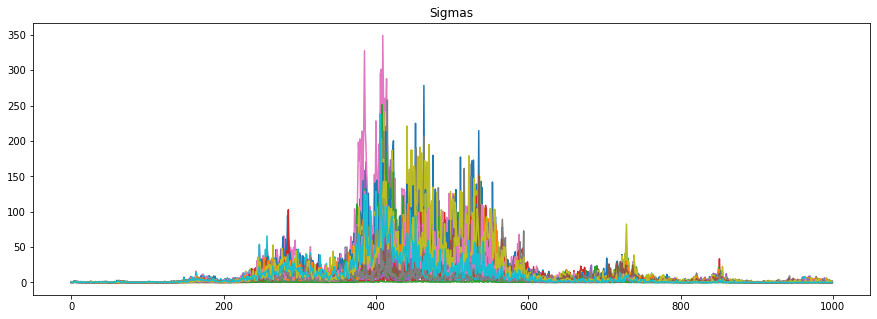

In [29]:
model.plot_sigmas(model.best_sigmas_history)

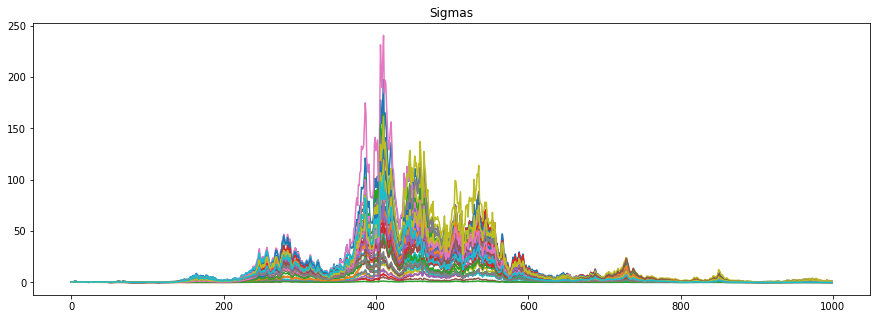

In [30]:
model.plot_sigmas(model.sigmas_history)

### 1.3 R^100

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 45.98it/s]


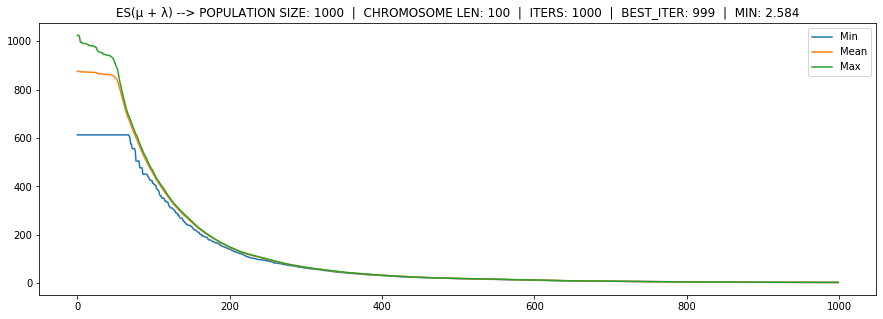

In [10]:
R = 100
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=sphere, 
           domain_l=[-5.12] * R, domain_r=[5.12] * R) 
model.run()
model.plot_cost()

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.04it/s]


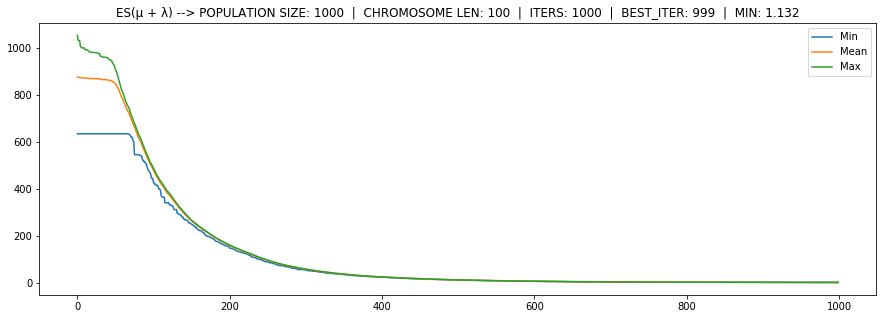

In [11]:
R = 100
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=sphere, 
           domain_l=[-5.12] * R, domain_r=[5.12] * R) 
model.run()
model.plot_cost()

### 1.3 R^200

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.96it/s]


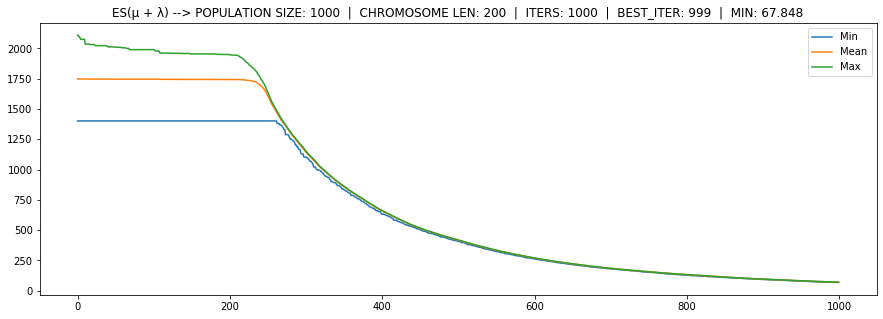

In [12]:
R = 200
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=sphere, 
           domain_l=[-5.12] * R, domain_r=[5.12] * R) 
model.run()
model.plot_cost()

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 23.09it/s]


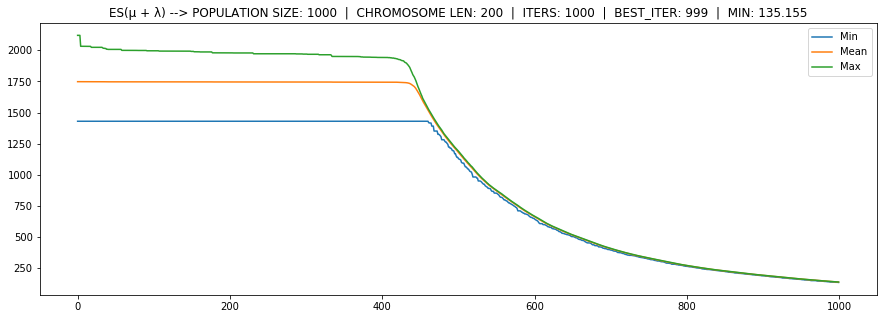

In [13]:
R = 200
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=sphere, 
           domain_l=[-5.12] * R, domain_r=[5.12] * R) 
model.run()
model.plot_cost()

## 2. Griewank Function

In [32]:
def griewank(P):
    score = (
        1
        + (P**2).sum(axis=1) / 4000
        - np.prod(
            np.cos(
                P/np.sqrt(
                    np.arange(1, P.shape[-1] + 1)
                )
            ),
            axis=1
        )
    )
    return score

ES(µ + λ): 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1487.59it/s]


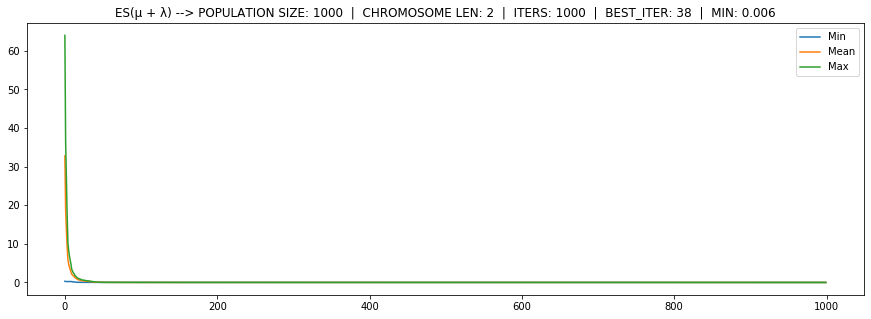

In [55]:
R = 2
model = ES(mode=1, iters=1000, mu=1000, lambda_=1500, chromosome_len=R, eval_f=griewank, K=0.9, 
           domain_l=[-600] * R, domain_r=[600] * R) 
model.run()
model.plot_cost()

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.45it/s]


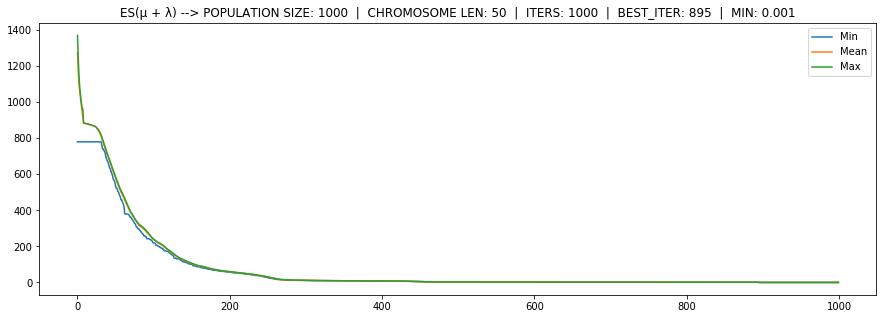

In [36]:
R = 50
model = ES(mode=1, iters=1000, mu=1000, lambda_=4000, chromosome_len=R, eval_f=griewank, K=0.9, 
           domain_l=[-600] * R, domain_r=[600] * R) 
model.run()
model.plot_cost()

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [01:45<00:00,  9.51it/s]


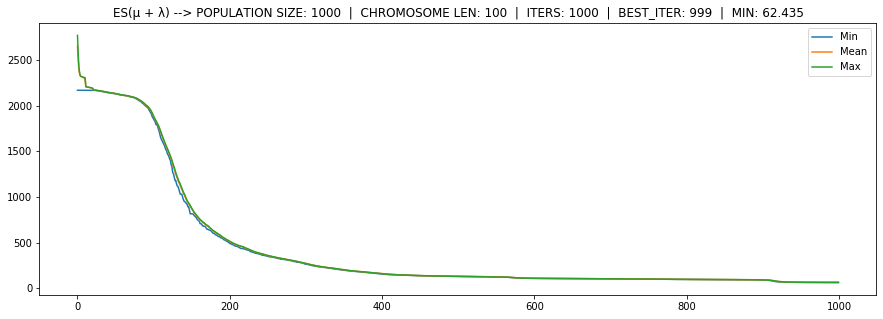

In [39]:
R = 100
model = ES(mode=1, iters=1000, mu=2000, lambda_=8000, chromosome_len=R, eval_f=griewank, K=0.9, 
           domain_l=[-600] * R, domain_r=[600] * R) 
model.run()
model.plot_cost()

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 1500/1500 [01:20<00:00, 18.58it/s]


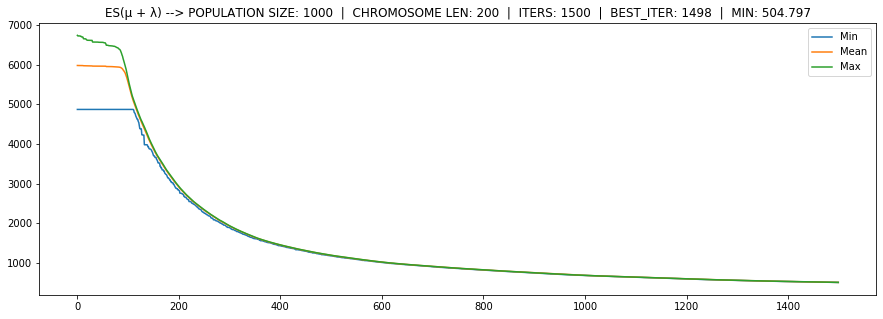

In [57]:
R = 200
model = ES(mode=1, iters=1500, mu=1000, lambda_=2000, chromosome_len=R, eval_f=griewank, 
           domain_l=[-600] * R, domain_r=[600] * R) 
model.run()
model.plot_cost()

## 3. Schwefel Function

In [50]:
def schwefel(P):
    n = P.shape[-1]
    score = np.sum(
        P * np.sin(
            np.sqrt(
                np.abs(P)
            )
        ),
        axis=1
    ) + 418.9829*n
    
#     penalty = [x for x in P if (x > 500).any() or (x < -500).any()]
#     if len(penalty) > 0:
#         [1e10] * n

    return score 

ES(µ + λ): 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1174.62it/s]


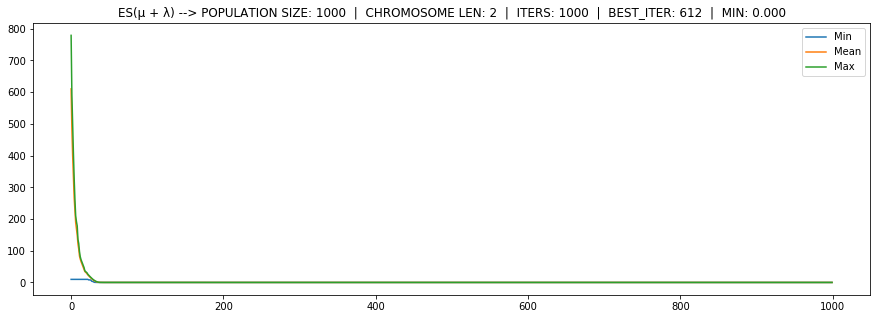

In [47]:
R = 2
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=schwefel, K=0.1,
           domain_l=[-500] * R, domain_r=[500] * R) 
model.run()
model.plot_cost()

ES(µ + λ): 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 476.28it/s]


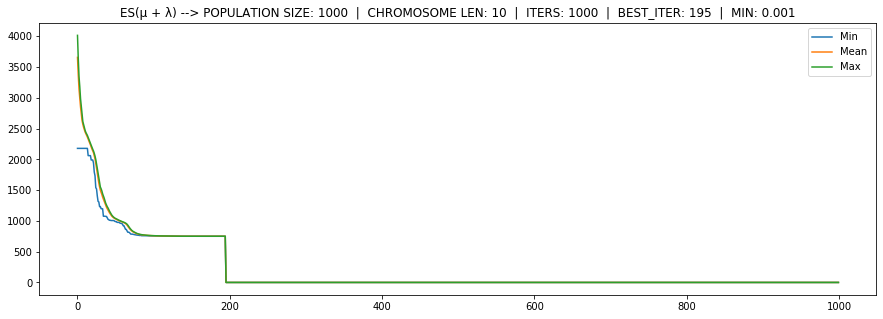

In [48]:
R = 10
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=schwefel, K=0.9,
           domain_l=[-500] * R, domain_r=[500] * R) 
model.run()
model.plot_cost()

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [02:38<00:00, 12.65it/s]


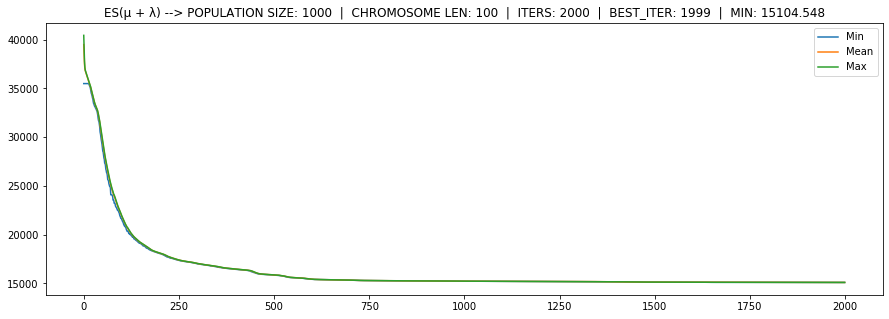

In [51]:
R = 100
model = ES(mode=1, iters=2000, mu=1000, lambda_=6000, chromosome_len=R, eval_f=schwefel, K=0.9,
           domain_l=[-500] * R, domain_r=[500] * R) 
model.run()
model.plot_cost()

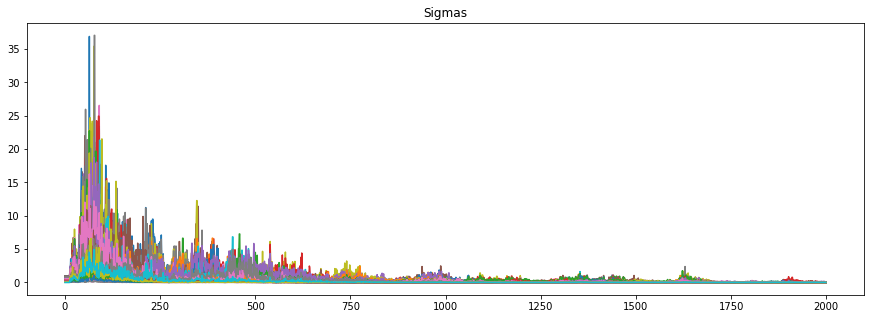

In [52]:
model.plot_sigmas(model.best_sigmas_history)

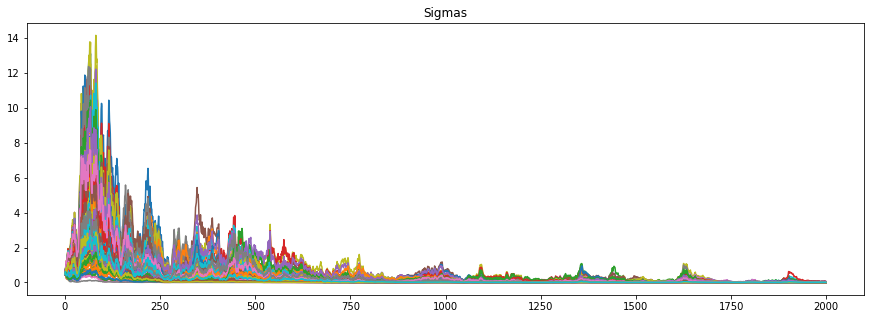

In [53]:
model.plot_sigmas(model.sigmas_history)

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 3000/3000 [02:40<00:00, 18.65it/s]


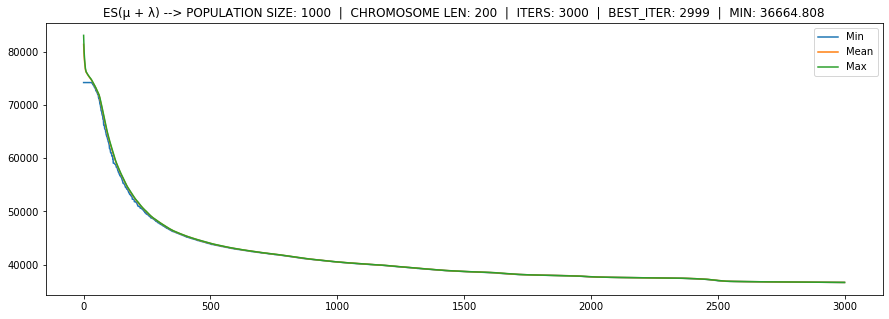

In [118]:
R = 200
model = ES(mode=1, iters=3000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=schwefel, 
           domain_l=[-500] * R, domain_r=[500] * R) 
model.run()
model.plot_cost()

## 4. Rastrigin Function

In [119]:

def rastrigin(P):
    n = P.shape[-1]
    score = (
        P**2 - 10 * np.cos(2*np.pi * P)
    ).sum(axis=1) + 10*n
    
    return score

ES(µ + λ): 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 491.46it/s]


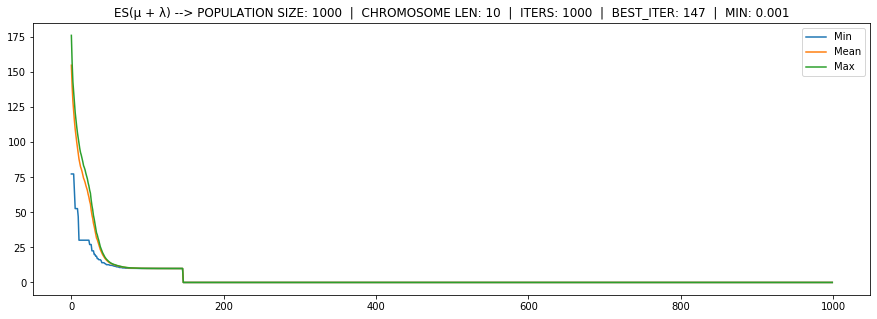

In [120]:
R = 10
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=rastrigin, 
           domain_l=[-5.12] * R, domain_r=[5.12] * R) 
model.run()
model.plot_cost()

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.47it/s]


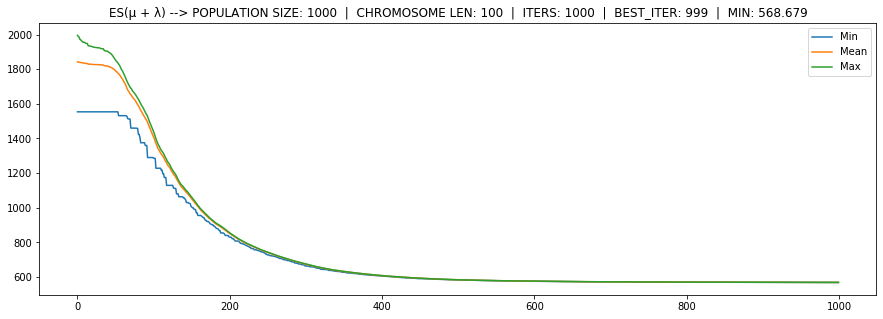

In [75]:
R = 100
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=rastrigin, 
           domain_l=[-5.12] * R, domain_r=[5.12] * R) 
model.run()
model.plot_cost()

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.67it/s]


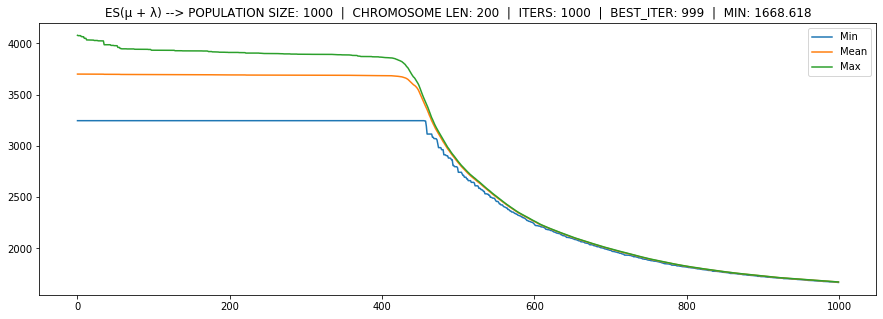

In [76]:
R = 200
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=rastrigin, 
           domain_l=[-5.12] * R, domain_r=[5.12] * R) 
model.run()
model.plot_cost()

## 5. Dixon & Price Function

In [139]:
def dp(P):
    score = (P[..., 0]-1)**2 + np.sum(
        (
            2 * P[..., 1:]**2 - P[..., :-1]**2
        ) ** 2 
        * np.arange(2, P.shape[-1] + 1), axis=1
    )
    
    return score


ES(µ + λ): 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 509.29it/s]


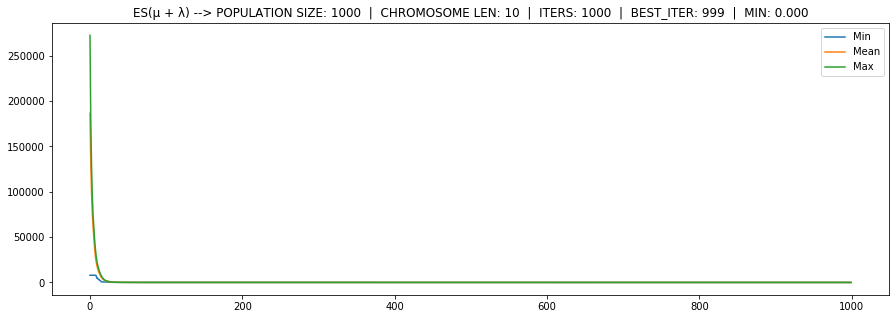

In [140]:
R = 10
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=dp, 
           domain_l=[-10] * R, domain_r=[10] * R) 
model.run()
model.plot_cost()

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.99it/s]


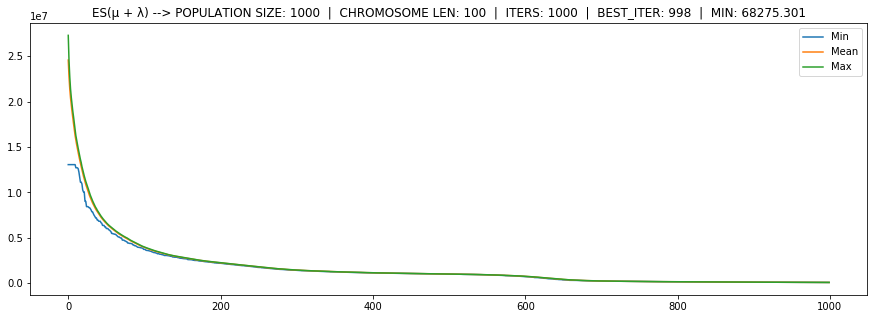

In [125]:
R = 100
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=dp, 
           domain_l=[-10] * R, domain_r=[10] * R) 
model.run()
model.plot_cost()

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.83it/s]


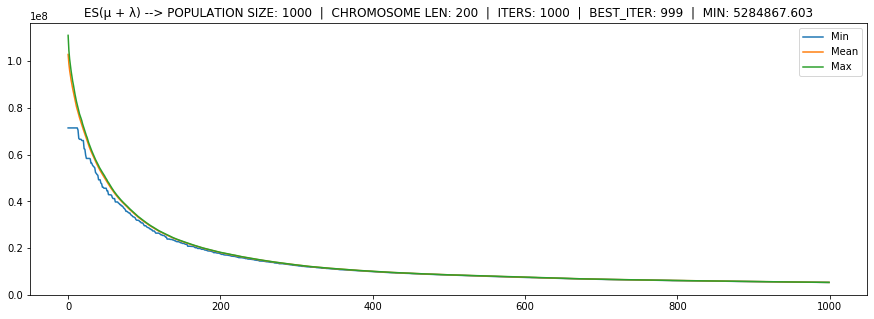

In [126]:
R = 200
model = ES(mode=1, iters=1000, mu=1000, lambda_=2000, chromosome_len=R, eval_f=dp, 
           domain_l=[-10] * R, domain_r=[10] * R) 
model.run()
model.plot_cost()